# Simple straight line fitting with three methods: grid search likelihood, MCMC and simulation-based inference
11/04/2024

Parameter estimation problem in Bayesian statistics: How to efficiently approximate the posterior?

This notebook shows the very basics of four different methods:
1. Computing prior and likelihood probabilities in all points of a grid in the parameter space
2. Using simple MCMC to sample from the posterior directly
3. Approximate Bayesian Computation: Simulate a bunch of mock observed data (with simulated noise) and draw the posterior directly from the simulations
4. Simulation-based inference (neural posterior estimation): Using machine learning to approximate the conversion from observed data to the posterior (x->P(theta|x))

In [311]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

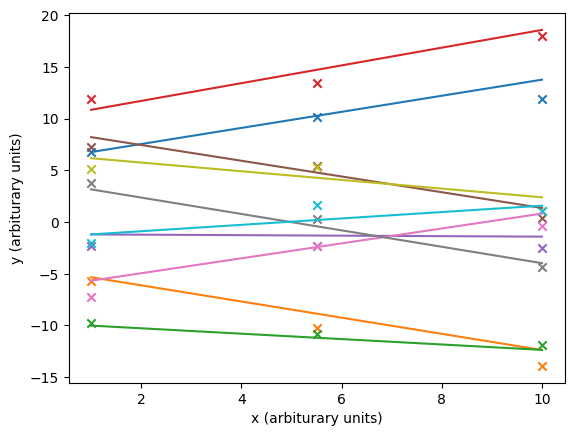

In [134]:
# define super simple linear line model
def model(x, m, c):
    return m*x + c

# We are observing the data of 10 objects
# generate the mock model parameters and their noise-less data for now
data_x = np.linspace(1,10,3)   # 3 data points per object
true_m = np.random.uniform(-1.0,1.0,10)
true_c = np.random.uniform(-10,10,10)
theta = np.vstack([true_m, true_c]).T

true_data = np.array([model(data_x, t[0], t[1]) for t in theta])

# add gaussian noise to true data to get observed data y
obs_sigma = 1.0
obs_data = true_data + np.random.randn(*np.shape(true_data))*obs_sigma

# make a plot for the mock observed data along with true data
for i in range(10):
    p0, = plt.plot(data_x, true_data[i])
    plt.scatter(data_x, obs_data[i], marker='x', color=p0.get_color())
    
plt.xlabel('x (arbiturary units)')
plt.ylabel('y (arbiturary units)')
plt.show()

## grid search with likelihood
The simplest but also normally the method that scales the worst with increasing dimentionality. This involves calculating the posterior/likelihood probability at a set of grid points populated throughout the theta parameter space. The number of evaluations increases with exp(n) where n is number of dimensions

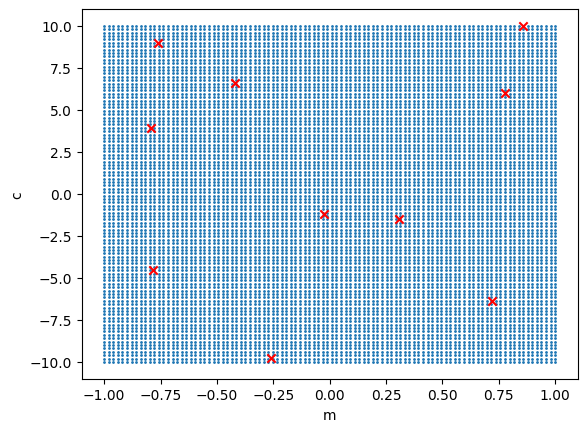

In [135]:
# m range from -1 to 1
m_grid = np.linspace(-1,1, 100)
# c range from -10 to 10
c_grid = np.linspace(-10, 10, 100)

theta_search_grid = np.meshgrid(m_grid, c_grid, indexing='ij')

# plot the grid for likelihood evalulations
plt.scatter(theta_search_grid[0], theta_search_grid[1], s=1)
plt.scatter(true_m, true_c, color='r', marker='x')
plt.xlabel('m')
plt.ylabel('c')
plt.show()

In [332]:
# define likelihood
def lnlike(theta, data_x, obs_y):
    mock_y = model(data_x, theta[0], theta[1])
    diff_y = obs_y - mock_y
    return (-0.5 * (diff_y / obs_sigma)**2).sum() 

In [333]:
# perform grid search
lnlike_grids = np.zeros((10, len(m_grid), len(c_grid)))
for i in range(len(obs_data)):
    #print(true_m[i], true_c[i])
    # loop through the combinations of m and c in the meshgrid
    for j,m_point in enumerate(m_grid):
        for k,c_point in enumerate(c_grid):
            lnlike_grids[i,j,k] = lnlike([m_point, c_point], data_x, obs_data[i])
            #print(m_point, c_point, lnlike_grids[i,j,k])
            
    # normalize the lnlikes
    likelihood_volume = np.sum(np.exp(lnlike_grids[i,:,:]), axis=(0,1))*(m_grid[1]-m_grid[0])*(c_grid[1]-c_grid[0])
    lnlike_grids[i,:,:] = lnlike_grids[i,:,:] - np.log(likelihood_volume)

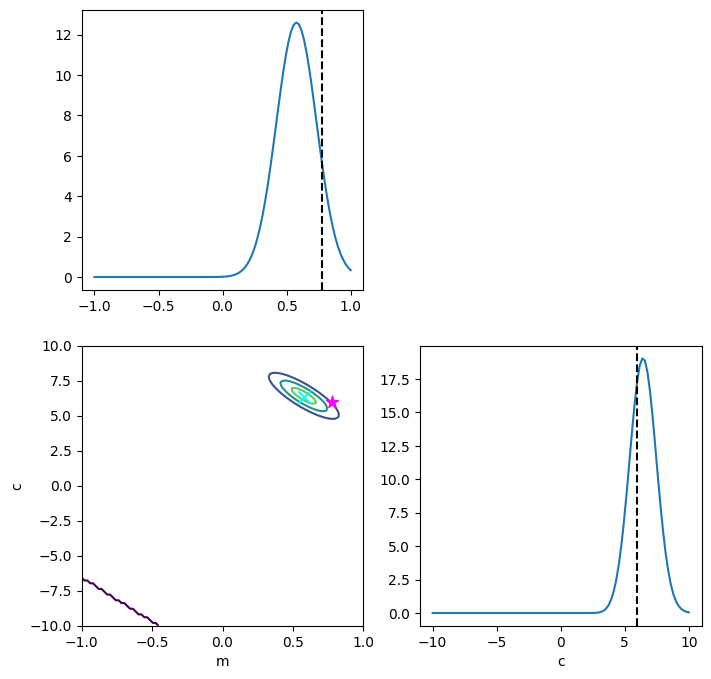

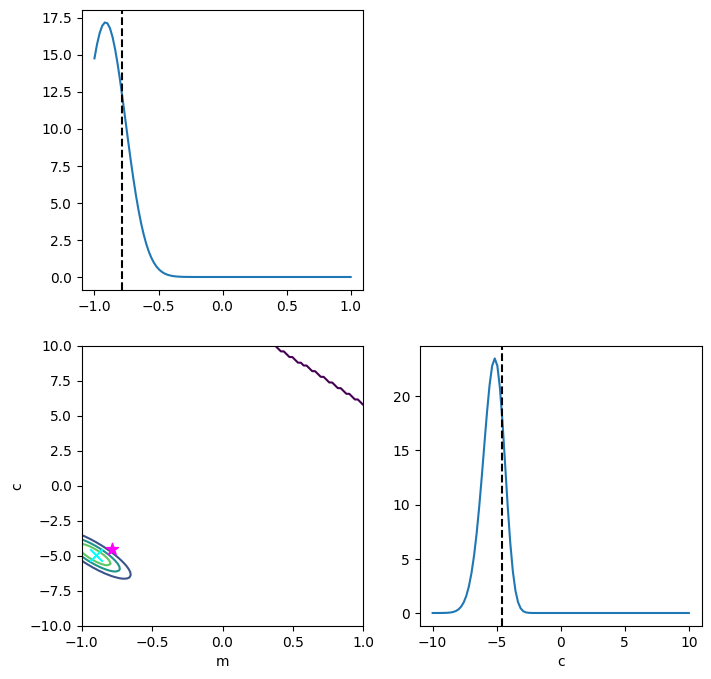

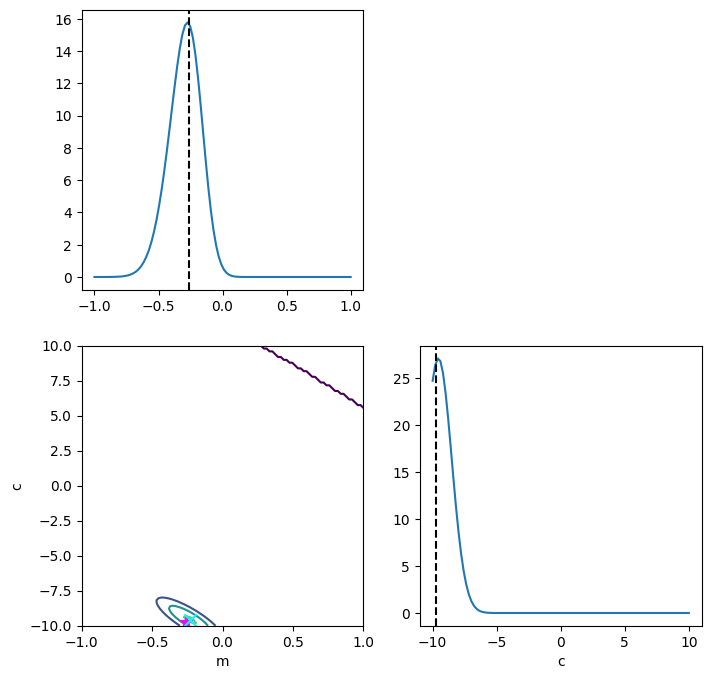

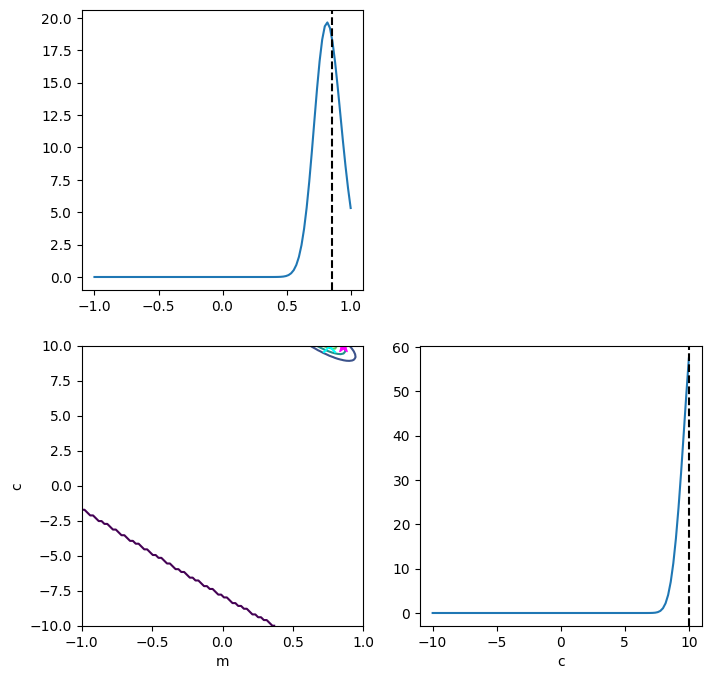

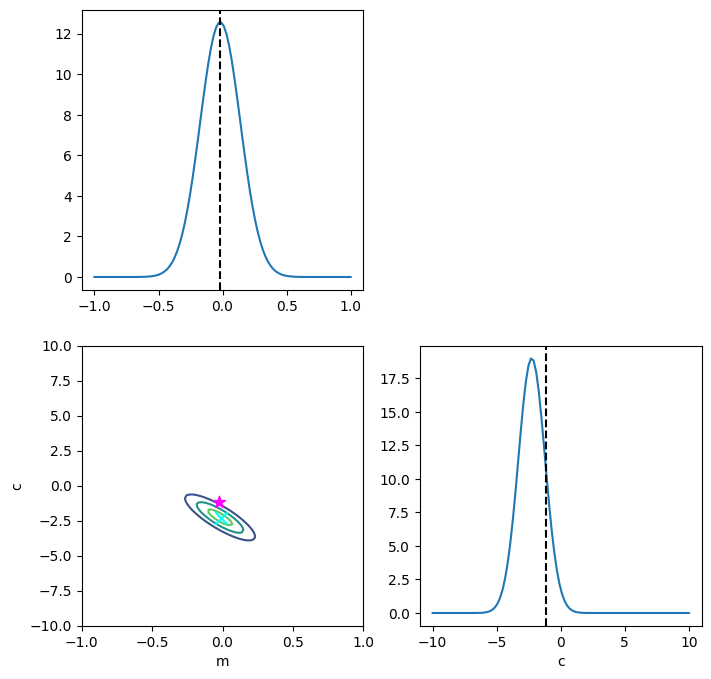

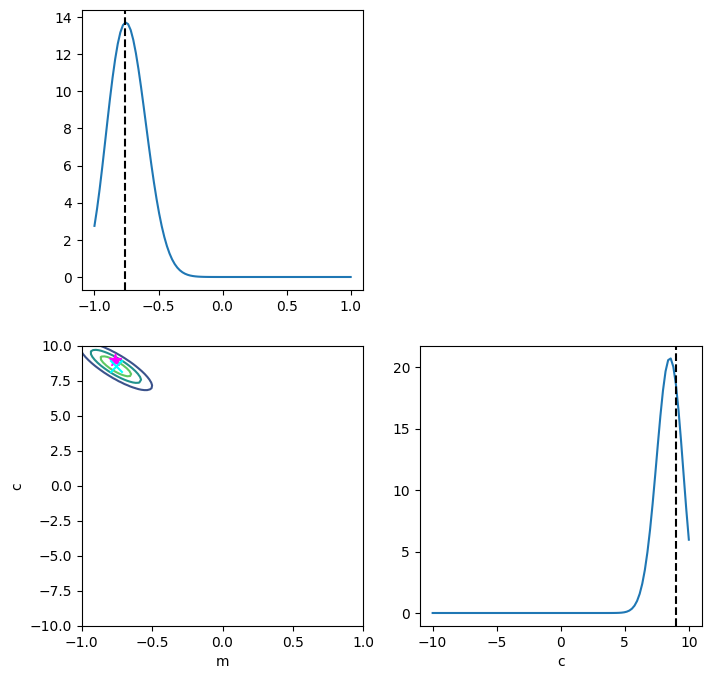

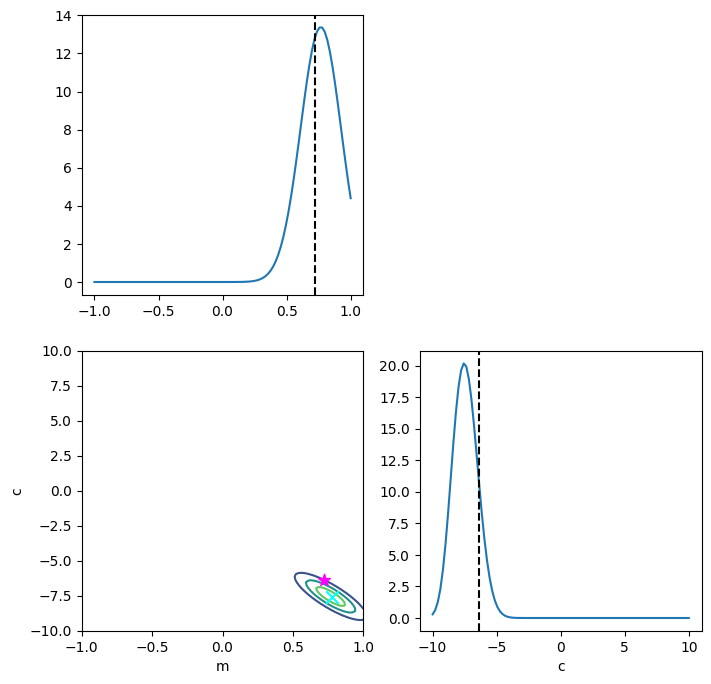

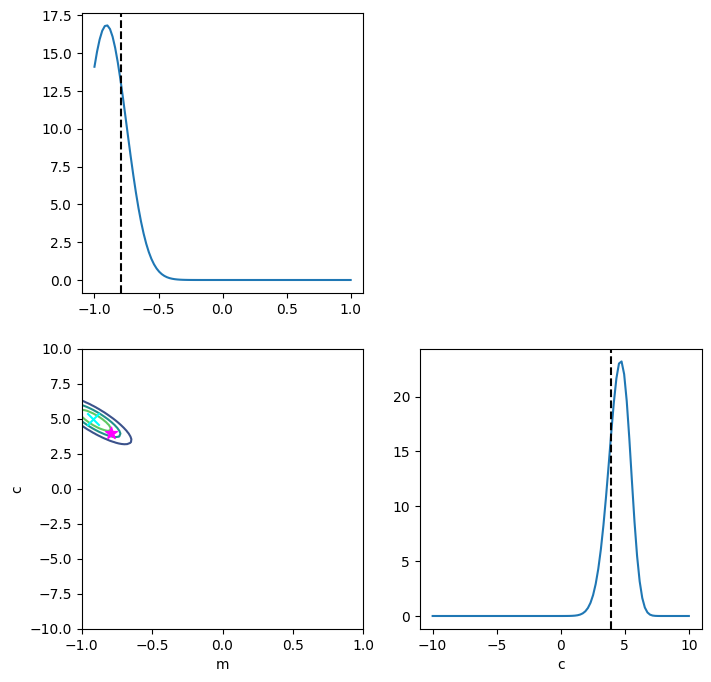

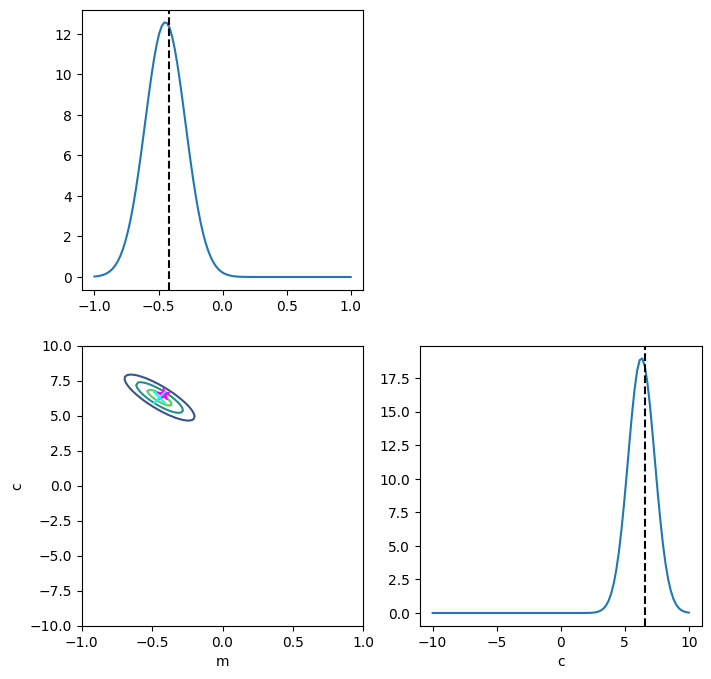

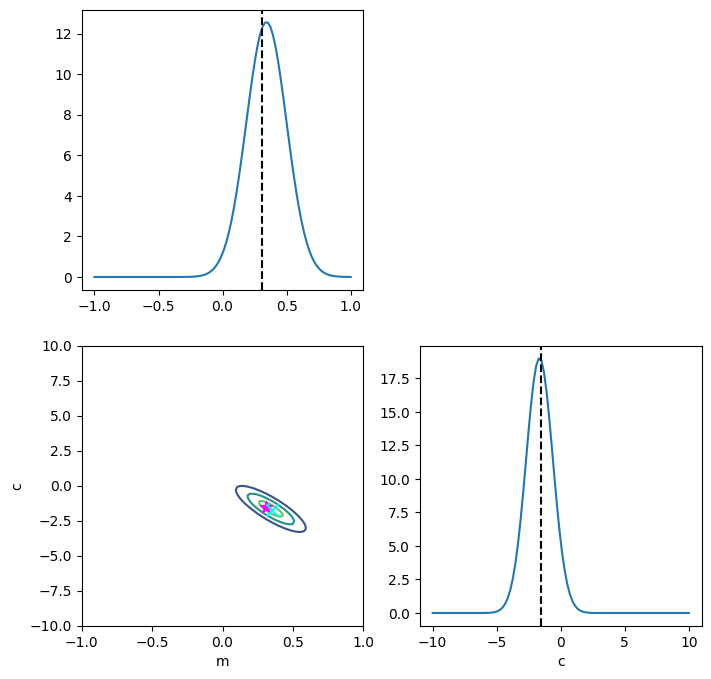

In [334]:
# plot the resulting posteriors
for i in range(len(obs_data)):
    
    fig,ax = plt.subplots(2,2, figsize=[8,8])
    
    # plot the posterior in colour maps or contours
    #ax[1,0].scatter(theta_search_grid[0], theta_search_grid[1], c=lnlike_grids[i,:,:], cmap='hot')
    ax[1,0].contour(theta_search_grid[0], theta_search_grid[1], np.exp(lnlike_grids[i,:,:]), 
                    levels=3, zorder=-1)
    
    # plot the maximum likelihood dot
    ind_max_lnlike = np.where(lnlike_grids[i,:,:]==np.max(lnlike_grids[i,:,:]))
    ax[1,0].scatter(theta_search_grid[0][ind_max_lnlike], theta_search_grid[1][ind_max_lnlike], color='aqua', 
                    marker='x', s=80)
    
    # true values
    ax[1,0].scatter(true_m[i], true_c[i], color='magenta', marker='*', s=80)
    
    # side histograms
    ax[0,0].plot(m_grid, np.sum(np.exp(lnlike_grids[i,:,:]), axis=1))
    ax[0,0].axvline(true_m[i], color='k', ls='--')
    ax[1,1].plot(c_grid, np.sum(np.exp(lnlike_grids[i,:,:]), axis=0))
    ax[1,1].axvline(true_c[i], color='k', ls='--')
    ax[0,1].axis('off')
    
    ax[1,0].set_xlabel('m')
    ax[1,0].set_ylabel('c')
    ax[1,1].set_xlabel('c')
    
    plt.show()

## Dumb MCMC version
See https://twiecki.io/blog/2015/11/10/mcmc-sampling/ for a nice explanation.

In [335]:
from scipy.stats import norm

def uniform_prior(value, min_val, max_val):
    # maps a value drawn from a uniform(0,1) prior into a desired uniform(min_val, max_val) prior
    return value*(max_val - min_val) + min_val

def prior_transform(cube):
    # maps a unit cube into our desired priors for each model parameter
    return_cube = np.zeros_like(cube)
    return_cube[0] = uniform_prior(cube[0], -1, 1)
    return_cube[1] = uniform_prior(cube[1], -10, 10)
    return return_cube

def sampler(data_x, obs_data, Nparams, prior_transform, Nchains=4, Nsteps=4, proposal_width=.05):
    # code adopted from https://twiecki.io/blog/2015/11/10/mcmc-sampling/ by Thomas Wiecki
    
    # initialize chains
    chain_init = np.random.rand(Nchains, Nparams)
    chain_return = {}
    
    for i in range(Nchains):
        # set first draw as initial positions
        unit_theta_current = chain_init[i]
        theta_current = prior_transform(unit_theta_current)
        
        # compute initial likelihood
        lnlike_current = lnlike(theta_current, data_x, obs_data)
        
        # keep track of things
        lnlike_history = [lnlike_current]
        samples = [theta_current]
        for j in range(Nsteps):
            # suggest new position
            unit_theta_proposal = norm(unit_theta_current, proposal_width).rvs()
            
            # transform with prior
            theta_proposal = prior_transform(unit_theta_proposal)
            
            # compute likelihood for both current and proposal
            lnlike_proposal = lnlike(theta_proposal, data_x, obs_data)
            
            # Accept proposal?
            p_accept = np.exp(lnlike_proposal-lnlike_current)
            accept = np.random.rand() < p_accept
            
            if accept:
                # Update position
                unit_theta_current = unit_theta_proposal
                theta_current = theta_proposal
                lnlike_current = lnlike_proposal
                
            samples.append(theta_current)
            lnlike_history.append(lnlike_current)
        
        # compile chains
        chain_return['chain '+str(i)] = {'samples': np.array(samples), 
                                         'lnlike': np.array(lnlike_history)}
        
    return chain_return

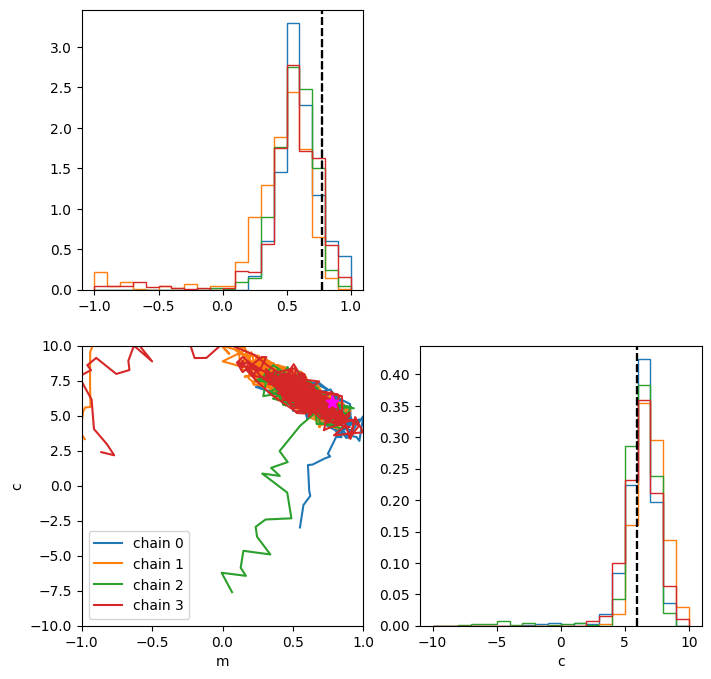

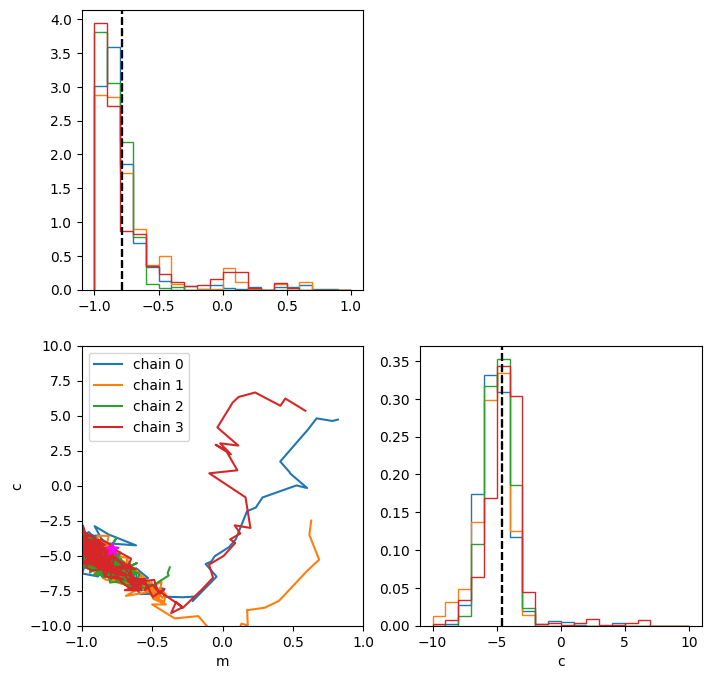

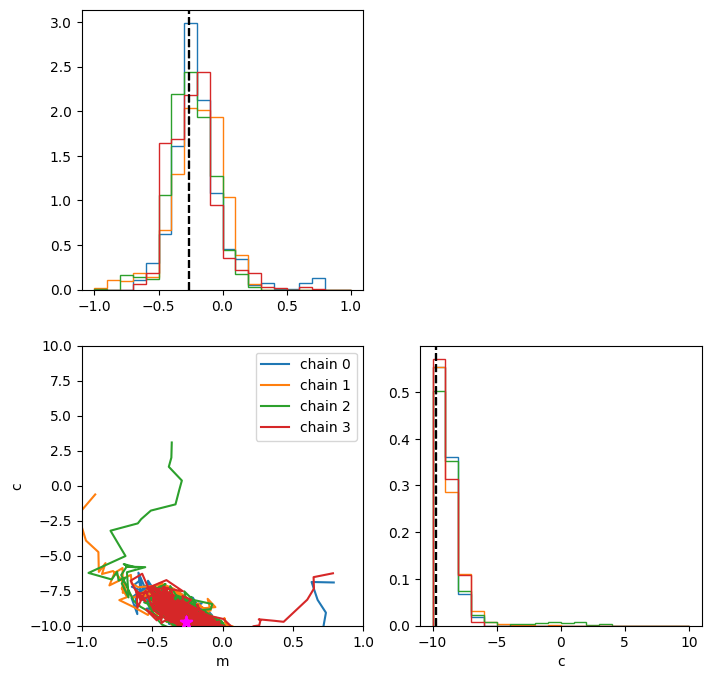

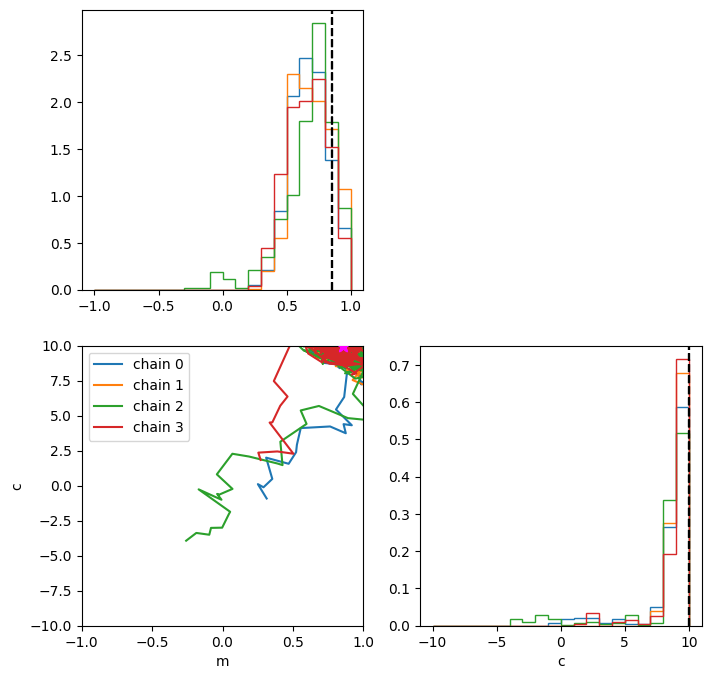

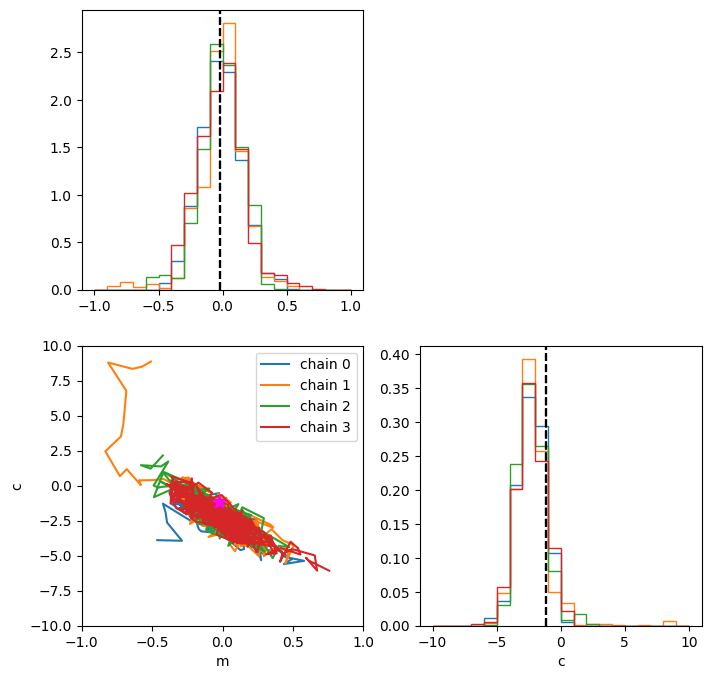

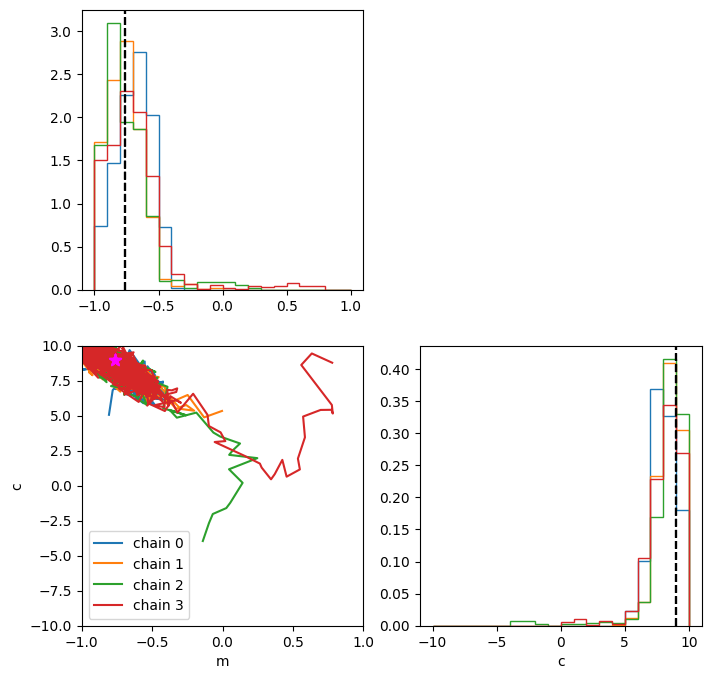

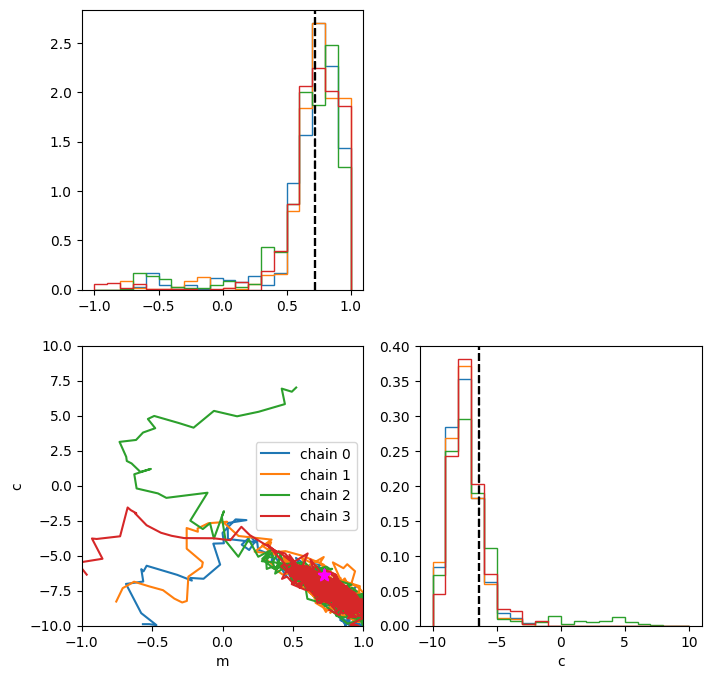

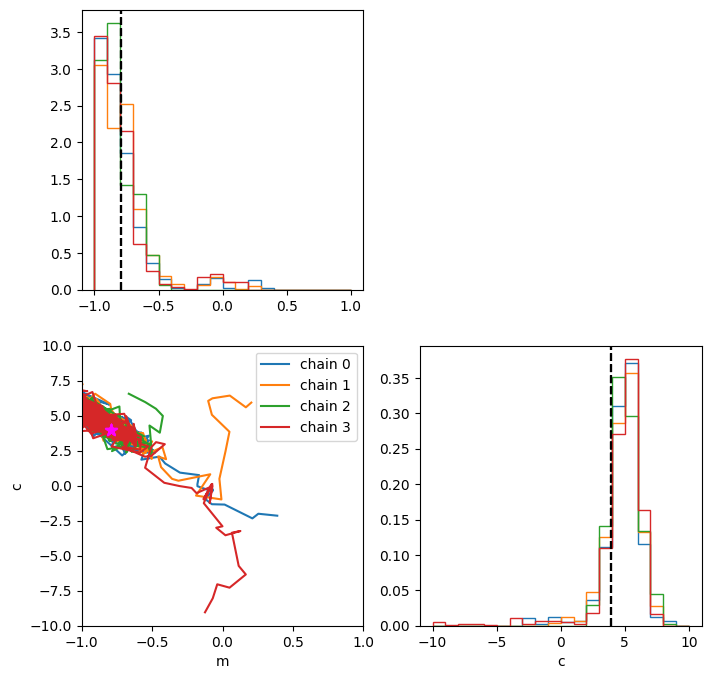

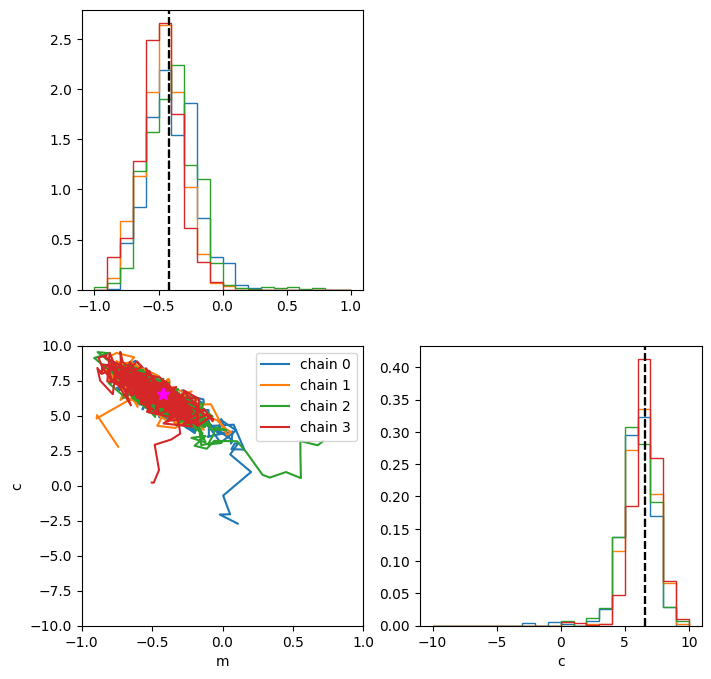

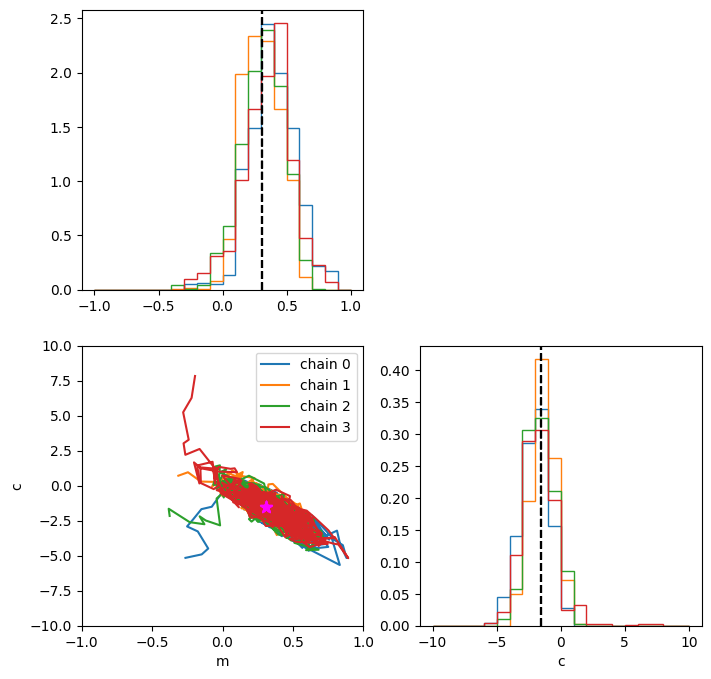

In [336]:
# running the sampler and make some plots!
results_list = []

for i in range(len(obs_data)):
    # running the sampler
    results = sampler(data_x, obs_data[i], 2, prior_transform, Nchains=4, Nsteps=1000)
    
    # bins to be used by the histograms
    m_bins = np.linspace(-1,1,21)
    c_bins = np.linspace(-10, 10, 21)
    
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    for chain_key in results:
        
        # plot the traces of each chain
        coords = results[chain_key]['samples']
        ax[1,0].plot(coords[:,0], coords[:,1], label=chain_key)
        
        # true values
        ax[1,0].scatter(true_m[i], true_c[i], color='magenta', marker='*', s=80, zorder=10)

        # m histogram
        h, _ = np.histogram(coords[:,0], bins=m_bins, density=True)
        ax[0,0].stairs(h, edges=m_bins)
        ax[0,0].axvline(true_m[i], color='k', ls='--')

        # c histogram
        h, _ = np.histogram(coords[:,1], bins=c_bins, density=True)
        ax[1,1].stairs(h, edges=c_bins)
        ax[1,1].axvline(true_c[i], color='k', ls='--')

        ax[0,1].axis('off')

    ax[1,0].set_xlim(min(m_bins), max(m_bins))
    ax[1,0].set_ylim(min(c_bins), max(c_bins))
    ax[1,0].legend()
    
    ax[1,0].set_xlabel('m')
    ax[1,0].set_ylabel('c')
    ax[1,1].set_xlabel('c')
    
    plt.show()
    
    results_list.append(results)

## simple Simulation-based inference/approximate bayesian computation
The idea is sometimes it is not possible/hard to explicitely write down the likelihood for a problem, or that the likelihood is very expensive to calculate. So something like MCMCs will not work for the problem. However, you might know the noise structure very well and it is possible to generate mock observations from input model parameters much more easily. In this situation, we build a simulator that takes in model parameters and spits out mock observations.

Then, the simulatior is fed random sets of parameter values drawn from your prior distribution many times. The idea of Approximate Bayesian computation is that, if we can match a number of simulations with close enough mock observation values to our real observation, the distribution of these matched simulations' input parameters will be a good approximation of the posterior.

The main draw back of this method is it is heavily cursed by increasing dimensionality, in both input parameter and the data.

In [160]:
# define our simulator
def simulator(theta, data_x, noise):
    mock_true_data = model(data_x, *theta)
    mock_data = mock_true_data + np.random.randn(len(mock_true_data))*noise
    return mock_data

# sample 10^6 random draws from the simulator
seed_sim = 12345
np.random.seed(seed_sim)
Nsim = int(1e6)

# proposal/prior distributions
proposal_m = np.random.uniform(low=-1, high=1, size=Nsim)
proposal_c = np.random.uniform(low=-10, high=10, size=Nsim)

theta = np.vstack([proposal_m, proposal_c]).T
simulated_data = np.array([simulator(t, data_x, obs_sigma) for t in theta])

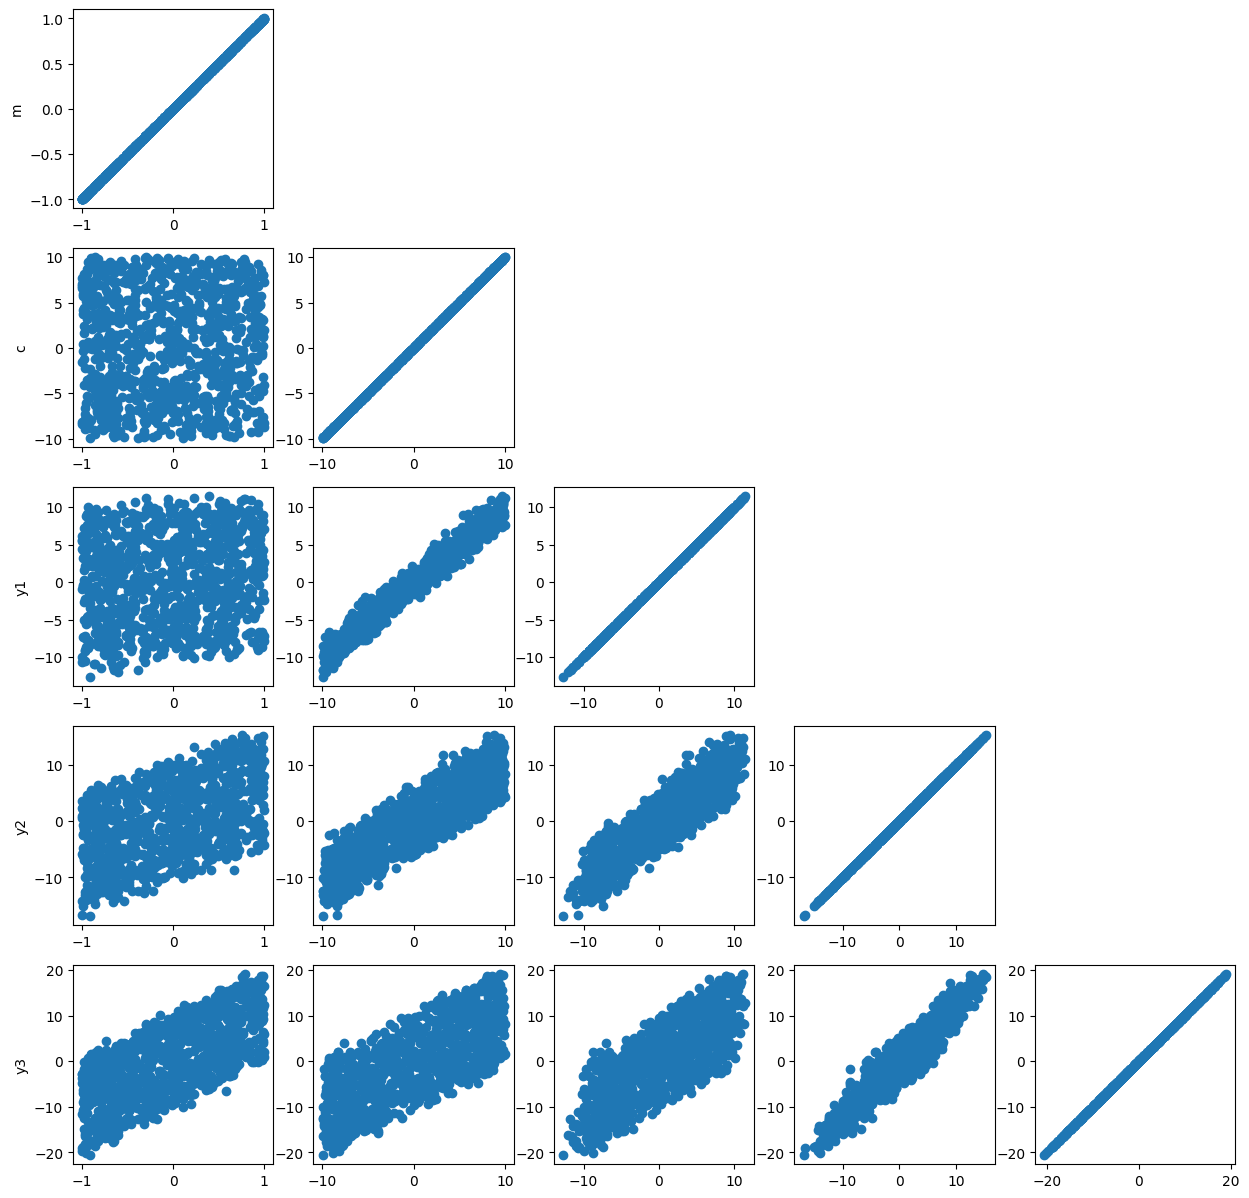

In [161]:
# plot massive corner plot of all axes of theta and all axes of data
Naxes = np.shape(theta)[1] + np.shape(simulated_data)[1]
combined_array = np.concatenate([theta, simulated_data], axis=1)
labels = ['m', 'c'] + [f'y{num+1}' for num in range(3)]

# only plot a random subset of the simulation draws
Ndots = 1000
plot_ind = np.random.choice(range(Nsim), size=Ndots)
#print(np.shape(combined_array))

fig,ax = plt.subplots(Naxes, Naxes, figsize=[3*Naxes, 3*Naxes])
for i in range(Naxes):
    for j in range(Naxes):
        if j<=i:
            ax[i,j].scatter(combined_array[plot_ind,j], combined_array[plot_ind,i])
            if j == 0:
                ax[i,j].set_ylabel(labels[i])
            if i == len(labels)-1:
                ax[i,j].set_xlabel(labels[j])
        else:
            ax[i,j].axis('off')
            
plt.show()

34943 34943.0
16962 2072.0
14171 245.0


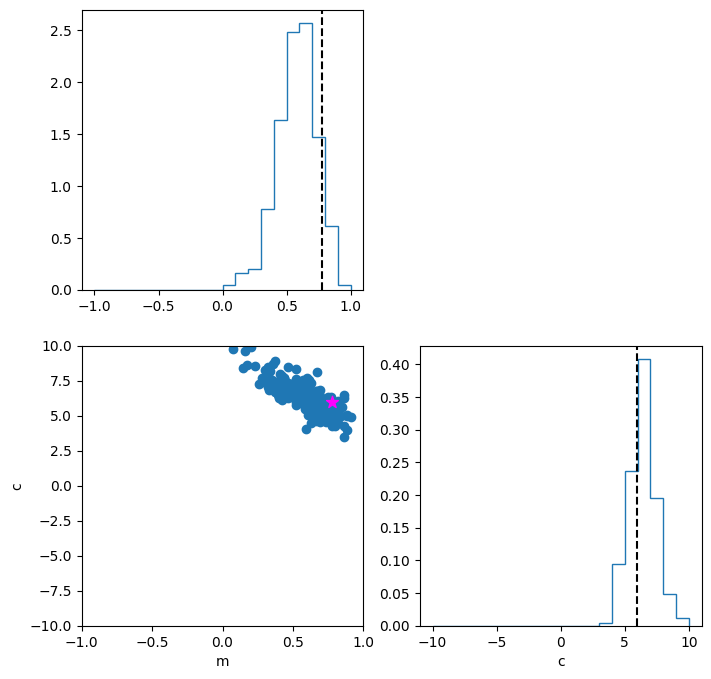

34828 34828.0
16821 1271.0
10600 176.0


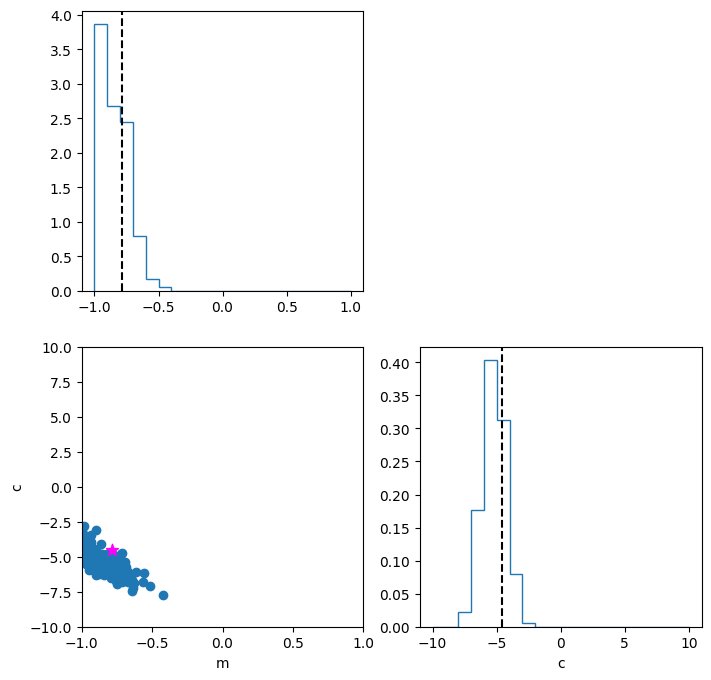

19976 19976.0
14711 1725.0
14322 190.0


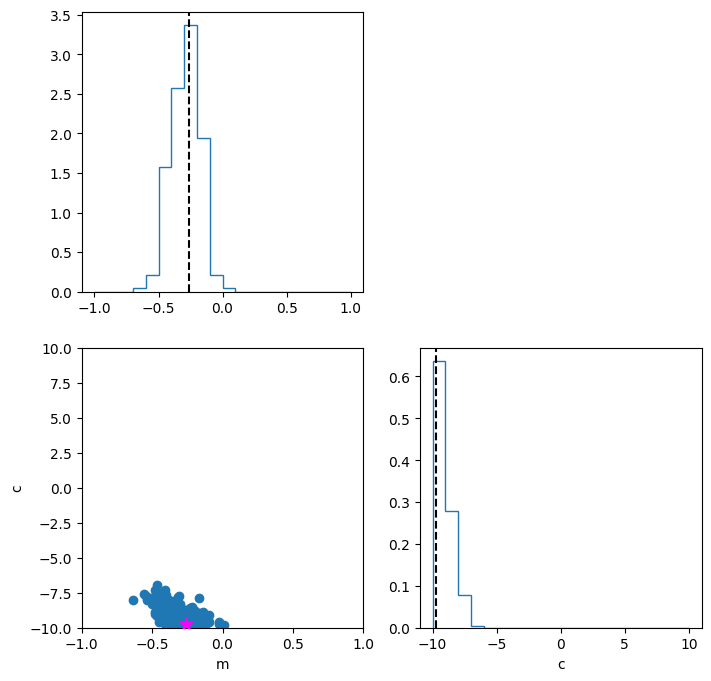

1790 1790.0
6624 250.0
3634 38.0


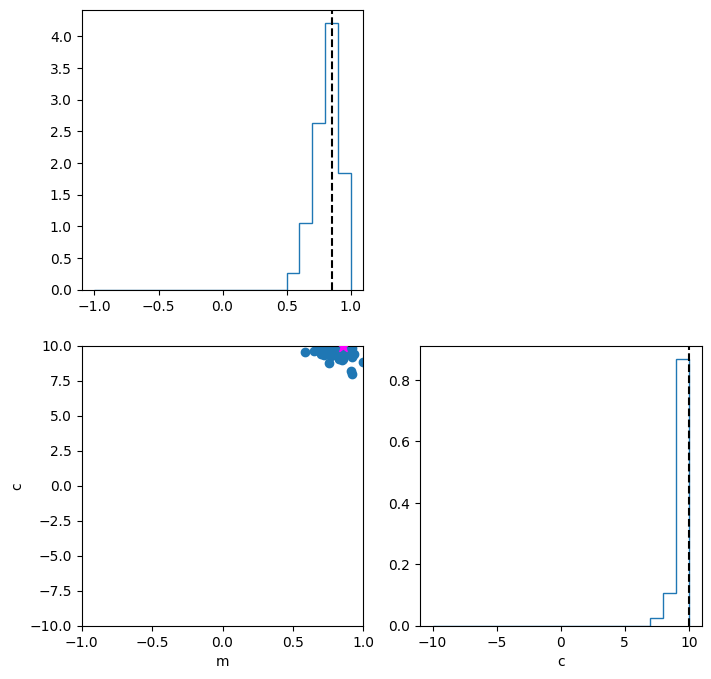

34768 34768.0
35187 2687.0
30660 295.0


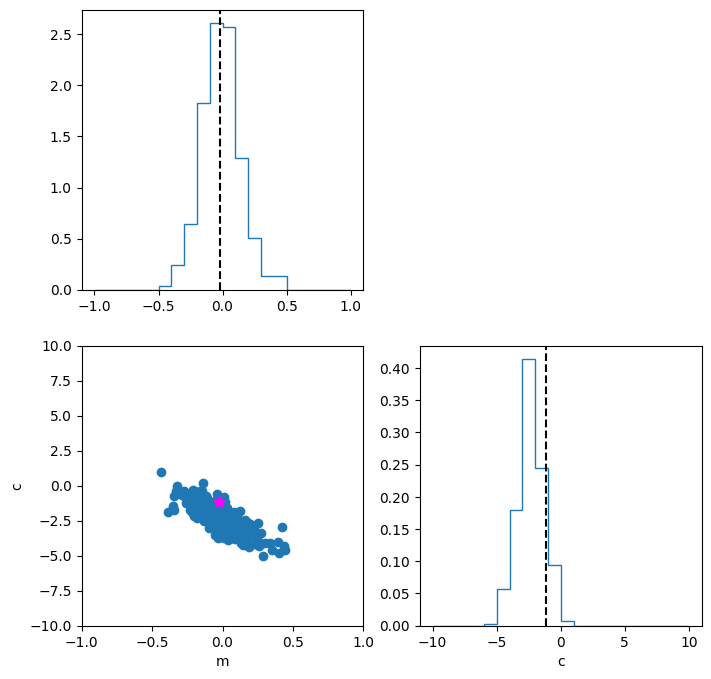

34738 34738.0
31898 2659.0
33281 142.0


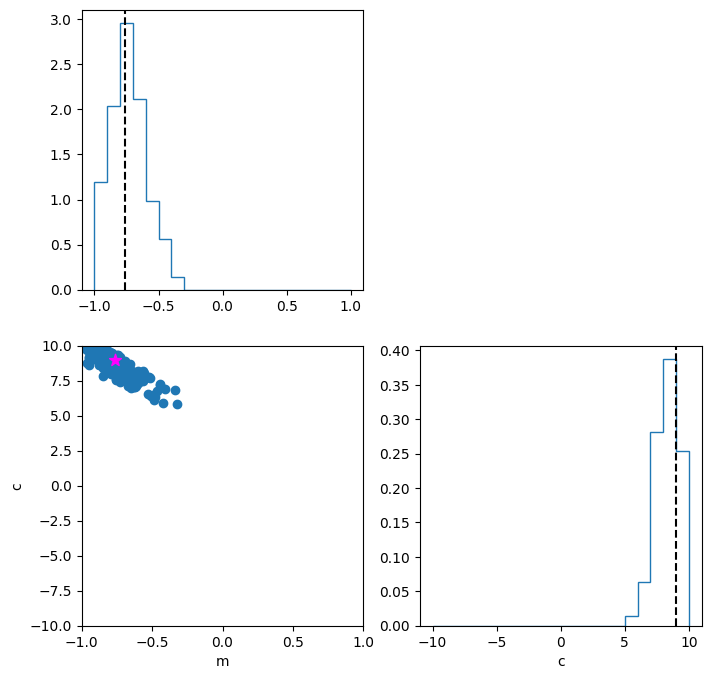

34609 34609.0
35267 1041.0
33696 152.0


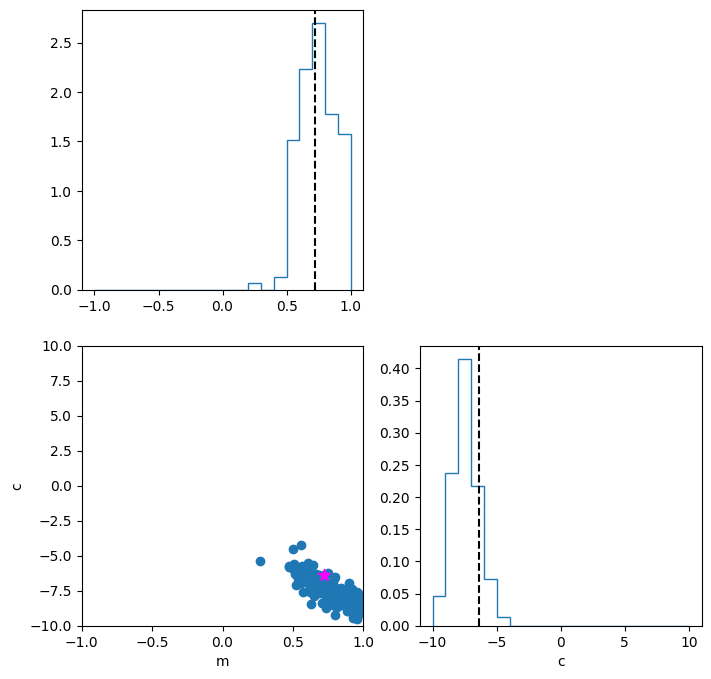

34956 34956.0
35440 2216.0
27377 211.0


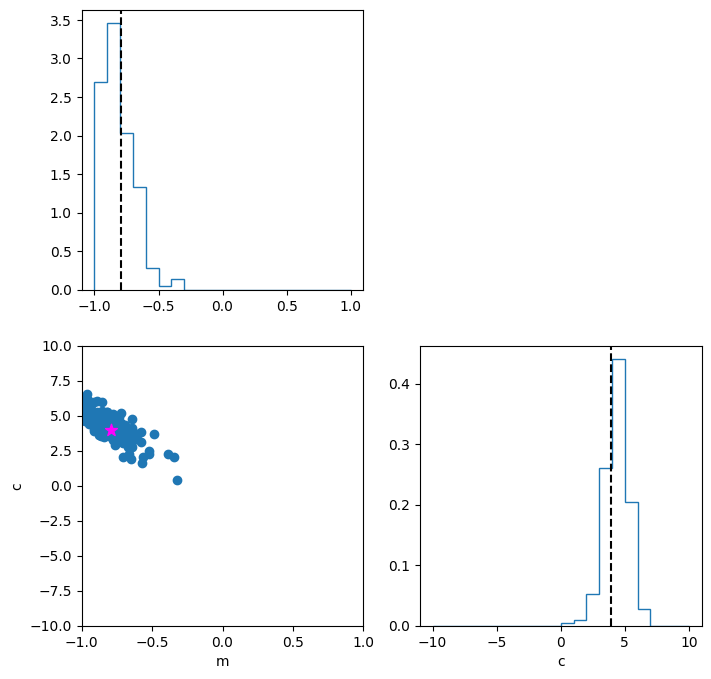

35552 35552.0
32222 2705.0
33028 59.0


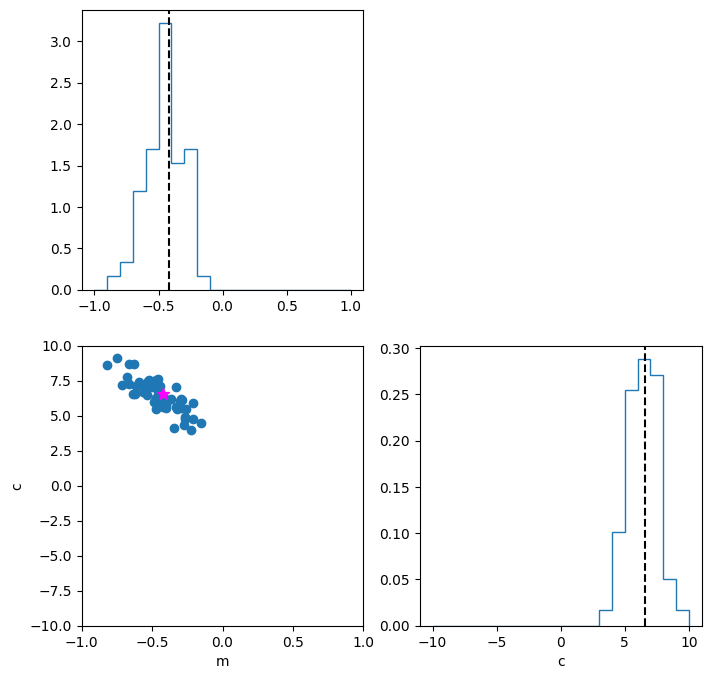

35002 35002.0
35023 1846.0
33053 55.0


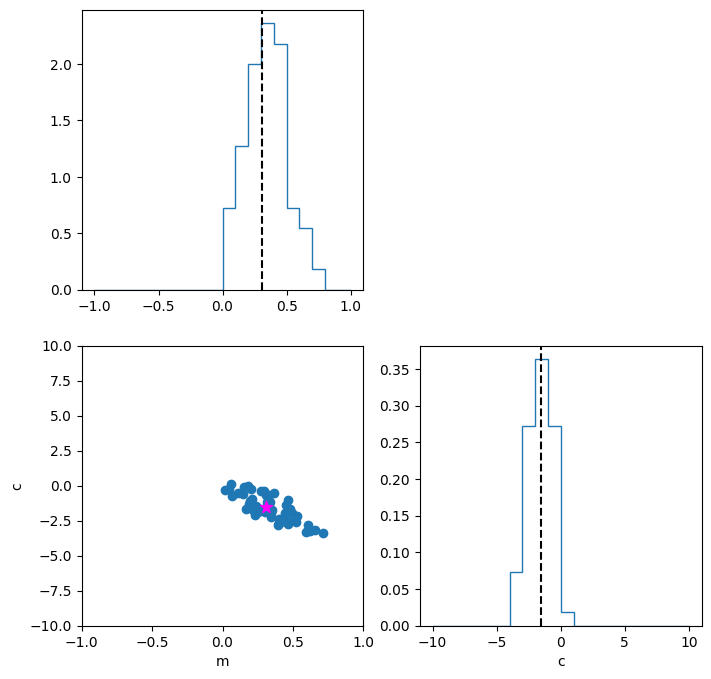

In [165]:
# now do slices in data space (all the ys) and find simulated data points that is close to or is in that slice
d_slice = 0.7           # tolerence width in all axes of y

sbi_samps = []

for i in range(len(obs_data)):

    # filter for simulations close to observed data
    mask = np.ones(len(simulated_data))
    for j in range(len(data_x)):
        m = (simulated_data[:,j]>obs_data[i,j]-d_slice/2) & (simulated_data[:,j]<=obs_data[i,j]+d_slice/2)
        mask *= m
        #print(sum(m), sum(mask))

    #print(np.where(mask))
    post_samps = theta[mask.astype(bool),:]

    m_bins = np.linspace(-1,1,21)
    c_bins = np.linspace(-10, 10, 21)

    fig,ax = plt.subplots(2,2,figsize=[8,8])
    
    # posterior samples
    ax[1,0].scatter(post_samps[:,0], post_samps[:,1])
    
    # true value
    ax[1,0].scatter(true_m[i], true_c[i], color='magenta', marker='*', s=80, zorder=10)

    # m histogram
    h, _ = np.histogram(post_samps[:,0], bins=m_bins, density=True)
    ax[0,0].stairs(h, edges=m_bins)
    ax[0,0].axvline(true_m[i], color='k', ls='--')

    # c histogram
    h, _ = np.histogram(post_samps[:,1], bins=c_bins, density=True)
    ax[1,1].stairs(h, edges=c_bins)
    ax[1,1].axvline(true_c[i], color='k', ls='--')

    ax[0,1].axis('off')

    ax[1,0].set_xlim(min(m_bins), max(m_bins))
    ax[1,0].set_ylim(min(c_bins), max(c_bins))

    ax[1,0].set_xlabel('m')
    ax[1,0].set_ylabel('c')
    ax[1,1].set_xlabel('c')

    plt.show()
    
    sbi_samps.append(post_samps)

## Simulation-based inference with machine learning (neural posterior estimator)
To work around the curse of dimensionality above, we can use machine learning to learn the mapping from observed data (in our case the three y values) to the posterior (in our case the joint posterior distribution between slope m and intercept c). This specific favour of Simulation-based inference is called neural posterior estimator. Assuming the neural network estimator is sufficiently trained, then we can directly query the estimator with each of our observations and get a posterior.

This part relies on the ltu-ili package: https://ltu-ili.readthedocs.io/en/latest/, and is based on their tutorial notebook: https://github.com/maho3/ltu-ili/blob/main/notebooks/tutorial.ipynb

In [233]:
import torch
import matplotlib.colors as mcolors

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


In [282]:
# make a dataloader, loading in our simulations. For speed, I am only feeding it the first 1e4 sims
loader = NumpyLoader(x=simulated_data[:10000,:], theta=theta[:10000,:])

# define a prior
prior = ili.utils.Uniform(low=[-1, -10], high=[1, 10], device=device)

# instantiate your neural networks to be used as an ensemble
# hidden_features ~ number of nodes in each hidden layer, num_transforms ~ number of hidden layers
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=5, num_transforms=5),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=7, num_transforms=5),
]

# define training arguments
train_args = {
    'training_batch_size': 1000,
    'learning_rate': 1e-3
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [283]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.


 Training neural network. Epochs trained: 481

INFO:root:Training model 2 / 2.


 Training neural network. Epochs trained: 304482 epochs.

/opt/anaconda3/lib/python3.8/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 204.12558269500732 seconds to train models.


 Neural network successfully converged after 305 epochs.

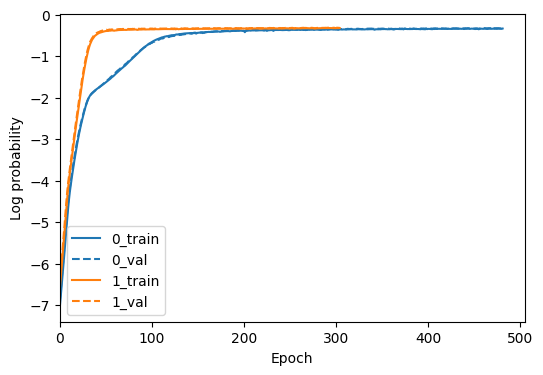

In [284]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()
plt.show()

In [285]:
# Now, SBIRunner returns a custom class instance to be able to pass signature strings
# This class has simply for attributes a NeuralPosteriorEstimate and a string list 
print(posterior_ensemble.signatures)

# generate samples from the posterior using accept/reject sampling
seed_samp = 32
torch.manual_seed(seed_samp)

samples = posterior_ensemble.sample((1000,), torch.Tensor(obs_data[0]).to(device))

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, torch.Tensor(obs_data[0]).to(device))

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

['', '']


Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

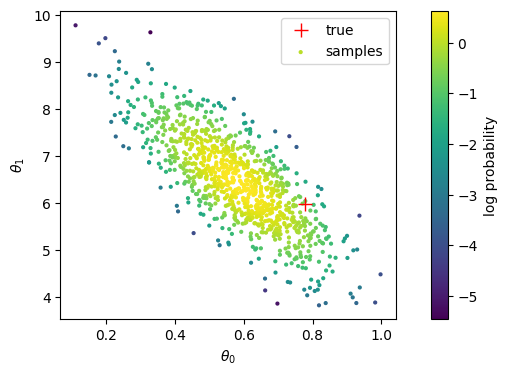

In [286]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, 2, figsize=(5,4), gridspec_kw={'width_ratios': [1,0.05]})
for i in range(1):
    axs[i].plot(true_m[0], true_c[0], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    #axs[i].set_aspect('equal')
    #axs[i].set_xlim(0,1)
    #axs[i].set_ylim(0,1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[-1])
plt.show()

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

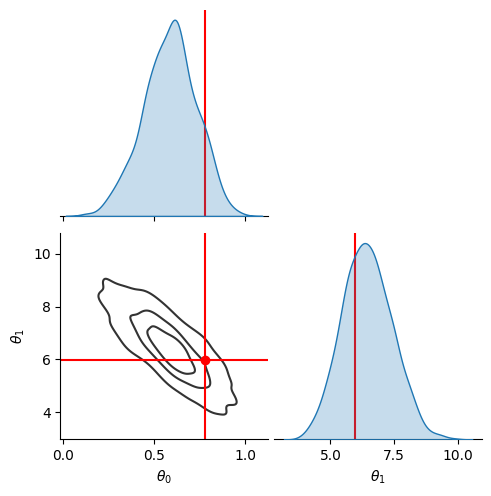

In [287]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(2)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = obs_data[0,:], theta_fid=np.array([true_m[0], true_c[0]])
)
plt.show()

100%|██████████| 100/100 [00:04<00:00, 20.39it/s]


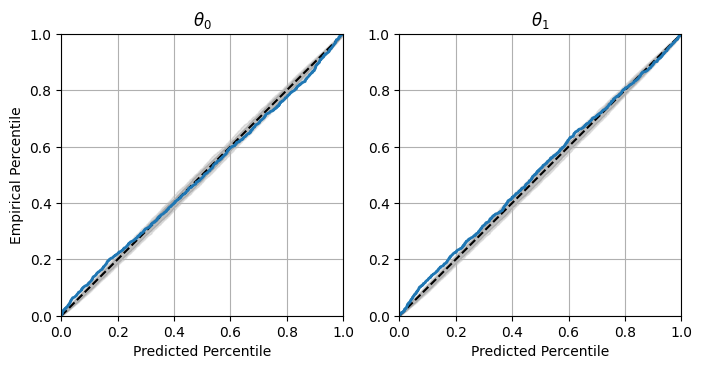

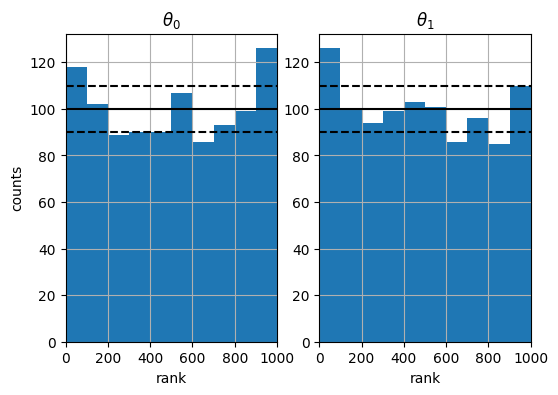

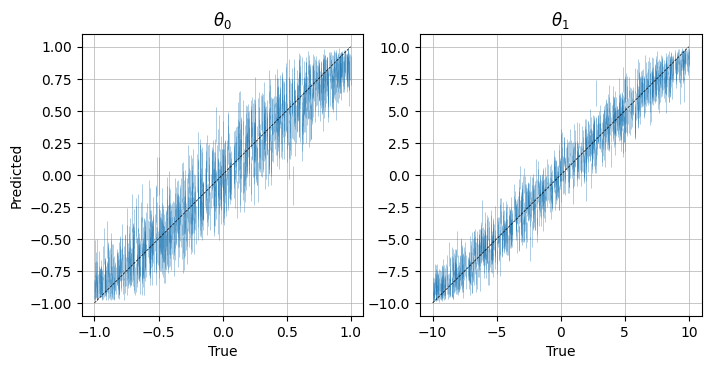

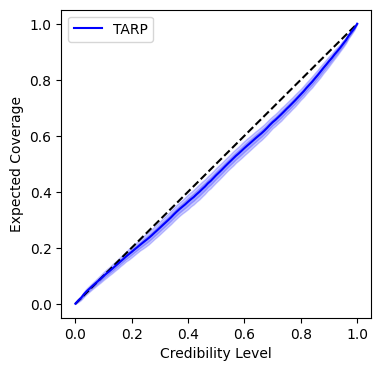

In [288]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(2)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=simulated_data[:1000,:], theta=theta[:1000,:]
)
plt.show()

In [308]:
# draw 1e5 samples from the posterior for each set of observation in our linear line problem
NPE_samples = []
for i in range(len(obs_data)):
    samples = posterior_ensemble.sample(
      x=obs_data[i], sample_shape=(10000,)
    )
    NPE_samples.append(samples)

Drawing 4904 posterior samples:   0%|          | 0/4904 [00:00<?, ?it/s]

Drawing 5096 posterior samples:   0%|          | 0/5096 [00:00<?, ?it/s]

Drawing 4967 posterior samples:   0%|          | 0/4967 [00:00<?, ?it/s]

Drawing 5033 posterior samples:   0%|          | 0/5033 [00:00<?, ?it/s]

Drawing 5054 posterior samples:   0%|          | 0/5054 [00:00<?, ?it/s]

Drawing 4946 posterior samples:   0%|          | 0/4946 [00:00<?, ?it/s]

Drawing 4994 posterior samples:   0%|          | 0/4994 [00:00<?, ?it/s]

Drawing 5006 posterior samples:   0%|          | 0/5006 [00:00<?, ?it/s]

Drawing 5030 posterior samples:   0%|          | 0/5030 [00:00<?, ?it/s]

Drawing 4970 posterior samples:   0%|          | 0/4970 [00:00<?, ?it/s]

Drawing 4937 posterior samples:   0%|          | 0/4937 [00:00<?, ?it/s]

Drawing 5063 posterior samples:   0%|          | 0/5063 [00:00<?, ?it/s]

Drawing 5032 posterior samples:   0%|          | 0/5032 [00:00<?, ?it/s]

Drawing 4968 posterior samples:   0%|          | 0/4968 [00:00<?, ?it/s]

Drawing 4983 posterior samples:   0%|          | 0/4983 [00:00<?, ?it/s]

Drawing 5017 posterior samples:   0%|          | 0/5017 [00:00<?, ?it/s]

Drawing 4971 posterior samples:   0%|          | 0/4971 [00:00<?, ?it/s]

Drawing 5029 posterior samples:   0%|          | 0/5029 [00:00<?, ?it/s]

Drawing 4939 posterior samples:   0%|          | 0/4939 [00:00<?, ?it/s]

Drawing 5061 posterior samples:   0%|          | 0/5061 [00:00<?, ?it/s]

# Compare posteriors between the four!
Ideally, since the theory basis for all four methods are sound, the posteriors should line up with each other. Let's see if this is true.

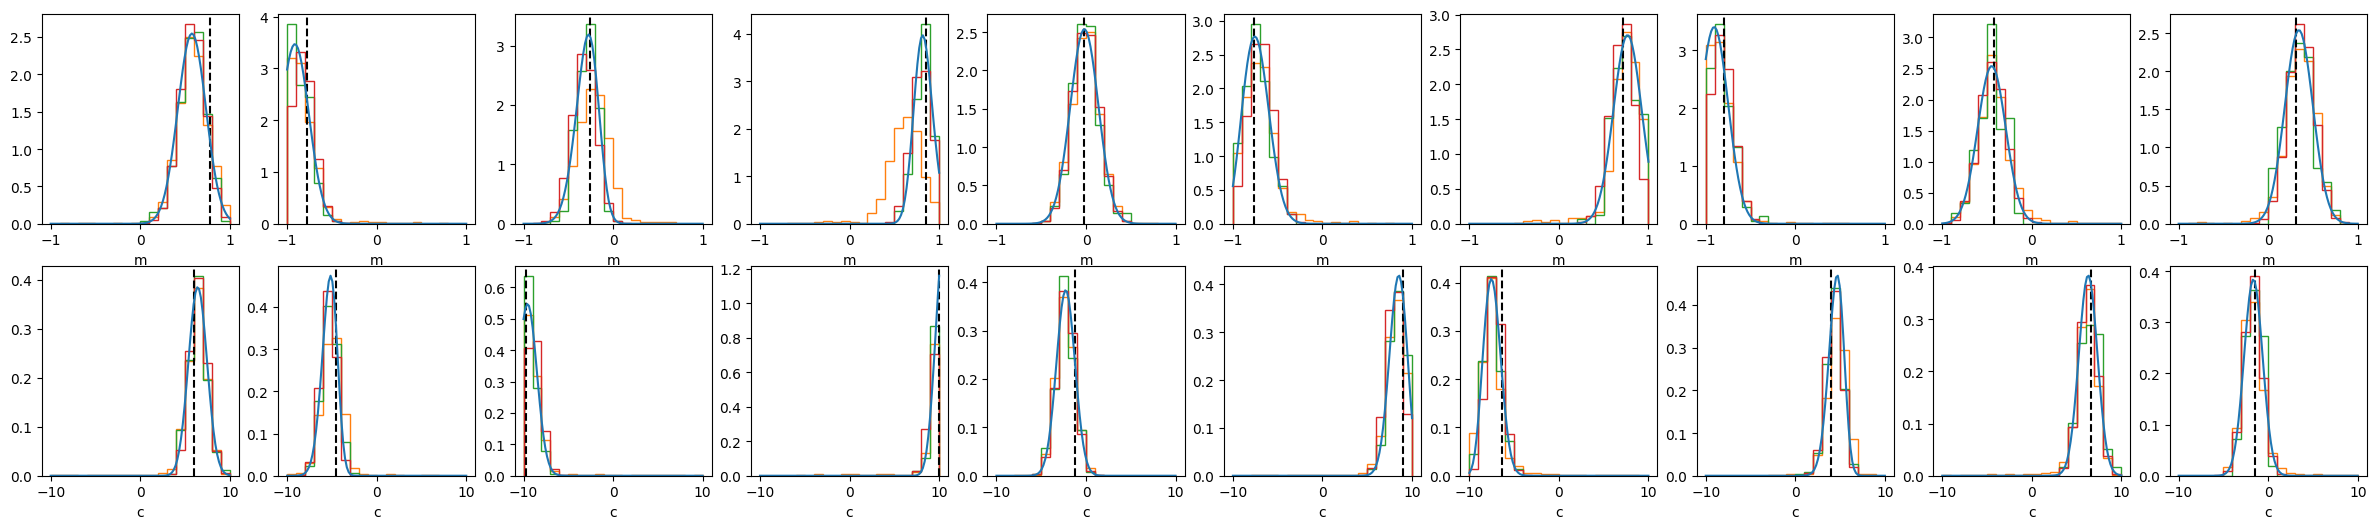

In [309]:
# 1D posteriors
fig,ax = plt.subplots(2, len(obs_data), figsize=[len(obs_data)*3, 2*3])
for i in range(len(obs_data)):
    # prep MCMC
    MCMC_samps = np.concatenate(
        [results_list[i][chain_key]['samples'] for chain_key in results_list[i].keys()], 
        axis=0)
    
    # m
    # truth
    ax[0,i].axvline(true_m[i], color='k', ls='--')
    # grid search
    lnlike_1D = np.sum(np.exp(lnlike_grids[i,:,:]), axis=1)*(c_grid[1]-c_grid[0])
    ax[0,i].plot(m_grid, lnlike_1D)
    # MCMC
    h, _ = np.histogram(MCMC_samps[:,0], bins=m_bins, density=True)
    ax[0,i].stairs(h, edges=m_bins)
    # ABC
    h, _ = np.histogram(sbi_samps[i][:,0], bins=m_bins, density=True)
    ax[0,i].stairs(h, edges=m_bins)
    # sbi
    h, _ = np.histogram(NPE_samples[i][:,0], bins=m_bins, density=True)
    ax[0,i].stairs(h, edges=m_bins)
    
    # c
    # truth
    ax[1,i].axvline(true_c[i], color='k', ls='--')
    # grid search
    lnlike_1D = np.sum(np.exp(lnlike_grids[i,:,:]), axis=0)*(m_grid[1]-m_grid[0])
    ax[1,i].plot(c_grid, lnlike_1D)
    # MCMC
    h, _ = np.histogram(MCMC_samps[:,1], bins=c_bins, density=True)
    ax[1,i].stairs(h, edges=c_bins)
    # ABC
    h, _ = np.histogram(sbi_samps[i][:,1], bins=c_bins, density=True)
    ax[1,i].stairs(h, edges=c_bins)
    # sbi
    h, _ = np.histogram(NPE_samples[i][:,1], bins=c_bins, density=True)
    ax[1,i].stairs(h, edges=c_bins)
    
    ax[0,i].set_xlabel('m')
    ax[1,i].set_xlabel('c')
    
plt.show()
    

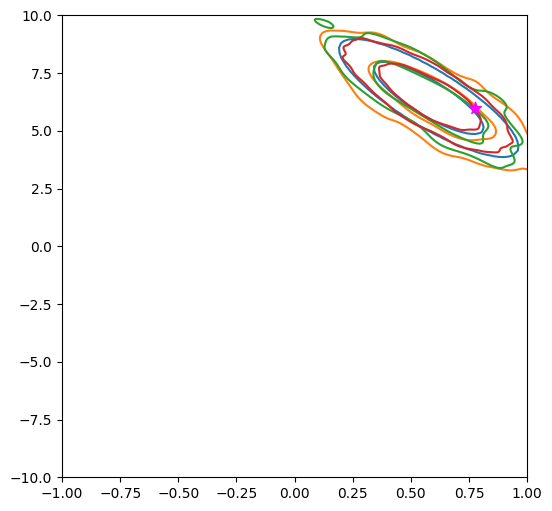

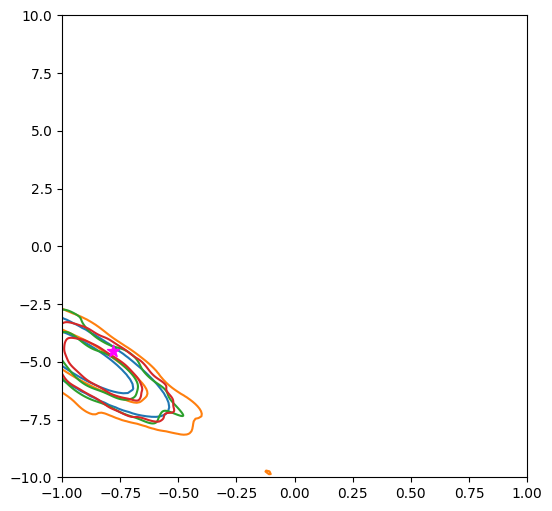

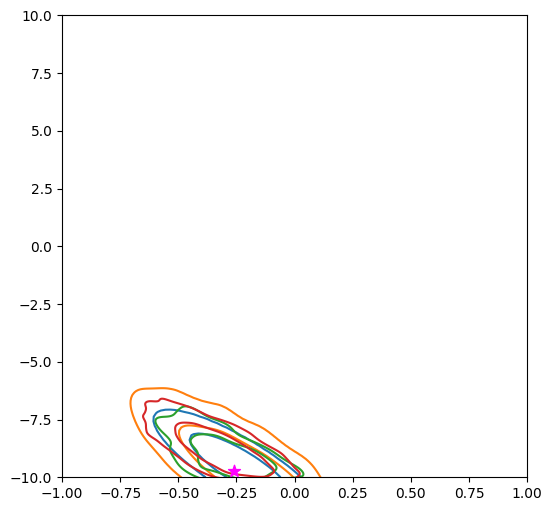

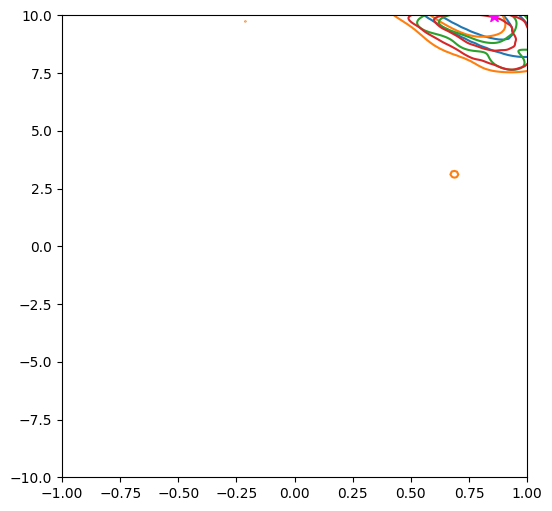

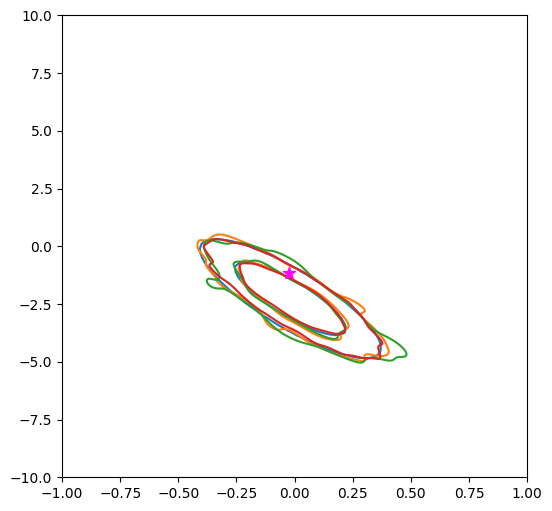

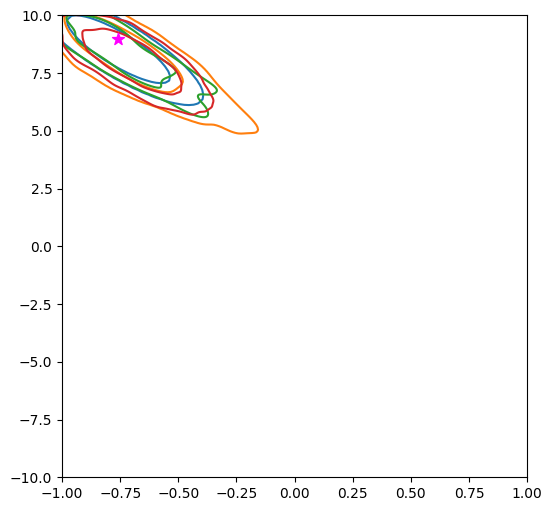

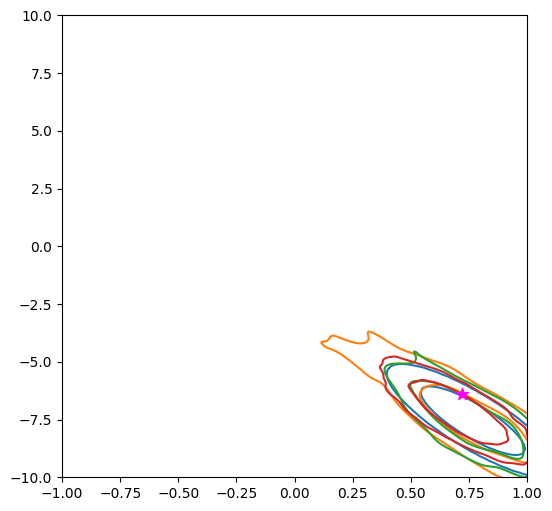

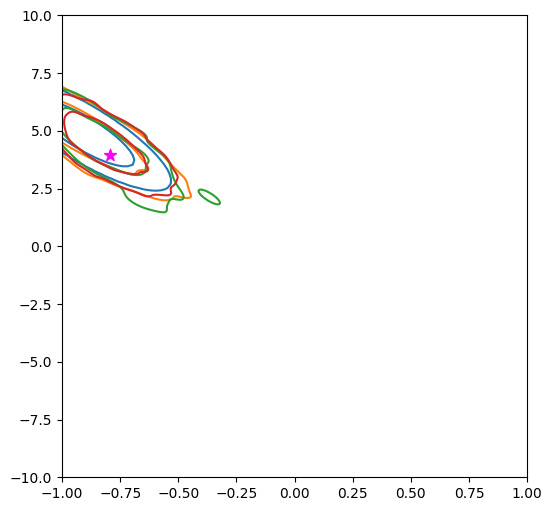

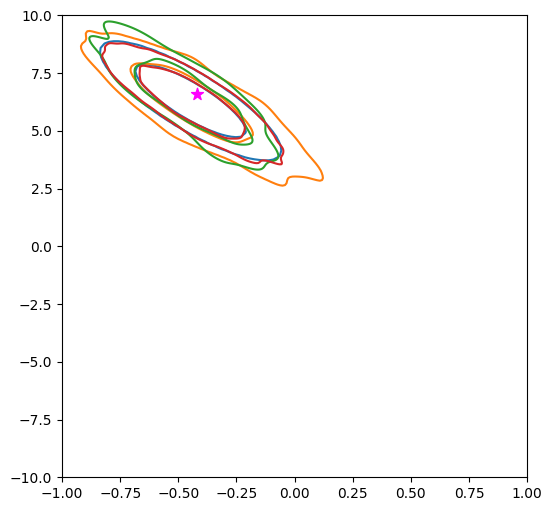

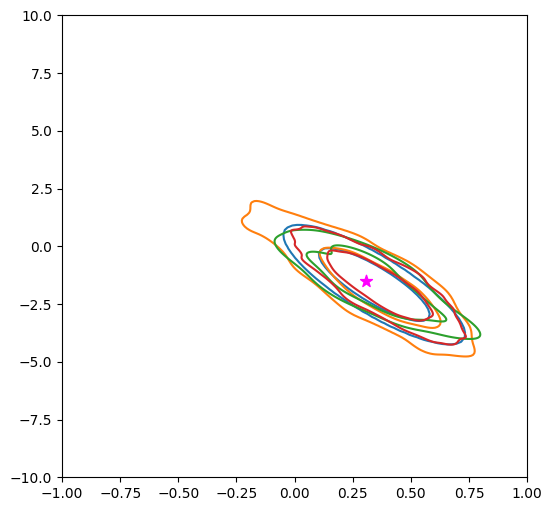

In [310]:
# 2D posteriors

for i in range(len(obs_data)):
    fig,ax = plt.subplots(figsize=[6,6])
    grid_area = (m_grid[1]-m_grid[0]) * (c_grid[1]-c_grid[0])
    
    # truth
    ax.scatter(true_m[i], true_c[i], marker='*', color='magenta', s=80, zorder=10)

    # grid search
    sorted_like = np.exp(np.sort(lnlike_grids[i,:,:].flatten()))
    cum_like = np.cumsum(sorted_like)*grid_area
    like_levels = np.interp([0.046,0.318], cum_like, sorted_like)
    ax.contour(theta_search_grid[0], theta_search_grid[1], np.exp(lnlike_grids[i,:,:]), 
                        levels=like_levels, colors='C0', zorder=-1)

    # MCMC
    MCMC_samps = np.concatenate(
        [results_list[i][chain_key]['samples'] for chain_key in results_list[i].keys()], 
        axis=0)
    sns.kdeplot(x=MCMC_samps[:,0], y=MCMC_samps[:,1], levels=[0.046,0.318], ax=ax, color='C1')

    # ABC
    sns.kdeplot(x=sbi_samps[i][:,0], y=sbi_samps[i][:,1], levels=[0.046,0.318], ax=ax, color='C2')
    
    # SBI
    sns.kdeplot(x=NPE_samples[i][:,0], y=NPE_samples[i][:,1], levels=[0.046,0.318], ax=ax, color='C3')

    ax.set_xlim(min(m_grid), max(m_grid))
    ax.set_ylim(min(c_grid), max(c_grid))
    
    plt.show()

And the posterior distributions do line up among the four methods, mostly. 

In most cases MCMC (orange) is the most different from the rest, especially when the true value is close to the edges of the prior. It often has wider posteriors (visible in both 1D and 2D plots) than the rest, due to a limited number of steps in each chain and the initialization of the chains in often low posterior likelihood regions. The initial "burn in" phase of each chain contributes to the wider posteriors. This is why more sophisicated MCMCs usually discard a set number of initial draws in each chain.

In some cases ABC (green) has the wiggliest 2D posterior contours. This is due to low sample number count, again, curse of dimensionality

In most cases the SBI 2D contours (red) matches the rest of the contours quite well, but can look truncated when the true value is near the edge of the priors. This is because the simulations we fed the neural network is truncated at the prior edges, which the neural network learnt as the true shape of the posterior at those parameter positions. Ideally we want the prior and the proposal distributions to be sufficiently wider than the true values' distributions.

Credits:
- Thanks to the hosts and participants of the SBI workshop in Bristol 2024 for introducing the topic of SBI and providing valueable tools
- Thanks to Adam Carnall for the idea of this exploration
- Thanks to Matt Ho for running the tutorial section on ltu-ili and helping with debugging the SBI portion of this notebook